# Up-and-out Call Option

The goal is to price a European up-and-out call option. This is a call option whose payoff becomes 0 if the share price gets too high over the lifetime of the option. Note that this limits the final payoff of the option, which subsequently makes it cheaper that a vanilla call option.

The payoff of this option at maturity $T$ is as follows:

> $\large v\left(S_T\right) =\left(S_T - K\right)^+ \text{ given } \underset{t \in [0, T]}{\max} S_t < L$

where $K$ is the strike of the option, $L$ is the barrier level, and $S_t$ is the share price at time $t$.

Observe that the payoff of the option is dependent on the value of the share price between the inception of the option and maturity. This means that the option payoff is dependent on the history of the share price, and not just its terminal value. As a result, you will need to simulate entire share price paths to estimate the price of this option. You may make the assumptions of the Black-Sholes-Merton model (i.e. assume that the stock value follow Geometric Brownian Motion with constant drift and volatilities.) 

> $\large S_t = S_0 exp\left( \left(r - \frac{\sigma^2}{2} \right)t + \sigma\sqrt{t}Z \right)$


Using the following parameters:

* The maturity of the option is in a year’s time

* The option is struck at-the-money

* The up-and-out barrier for the option is \$150

* The current share price is \$100

* The risk-free continuously compounded interest rate is 8%

* The volatility for the underlying share is 30%




In [1]:
# Market information
r = 0.08 # risk-free rate

# Share specific information
S_0 = 100    # initial share price
sigma = 0.30 # volatility

# Option specific information
K = 100 # strike price
T = 1.0 # term of contract
L = 150 # up-and-out barrier


1. Simulate paths for the underlying share value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.


In [2]:
import numpy as np
from scipy.stats import norm

np.random.seed(0)

def option_payoff(S_0, r, sigma, Z, t, L):
    '''Generates the option payoff given some some random normal values Z'''
    S_t = S_0*np.exp((r - sigma**2/2)*t + sigma*np.sqrt(t)*Z)
    S_m = np.amax(S_t, axis=1)  # max value of each row
    S_T = S_t[:,-1]             # terminal value of each row
    return S_T * (S_m < L)

def discounted_call_payoff(S_T, K, r, T):
    '''Function for evaluating the discounted payoff of a call in a Monte Carlo Estimation'''
    return np.exp(-r*T)*np.maximum(S_T-K, 0)

call_est = [None]*50
call_std = [None]*50

months = int(T*12)

for i in range(1, 51):
    # First simulate option prices
    t = np.arange(1/12, (months + 1)/12, 1/12)
    Z_s = norm.rvs(size = [i*1000, months])
    S_T = option_payoff(S_0, r, sigma, Z_s, t, L)
    call_val = discounted_call_payoff(S_T, K, r, T)
    call_est[i-1] = np.mean(call_val)
    call_std[i-1] = np.std(call_val)/np.sqrt(i*1000)
        

2. Determine analytical value of the option and compare with the Monte Carlo estimate.


The analytical call price of the up-and-out call option is given by [1]:

> $\large V(0) = S_0 \left[ \Phi \left( \delta_{+}\left( T, \frac{S_0}{K}\right) \right) - \Phi \left( \delta_{+}\left( T, \frac{S_0}{L}\right) \right) \right]\\
-e^{-rT} K \left[ \Phi \left( \delta_{-}\left( T, \frac{S_0}{K}\right) \right) - \Phi \left( \delta_{-}\left( T, \frac{S_0}{L}\right) \right) \right]\\
-L\left( \frac{S_0}{L} \right)^{-\frac{2r}{\sigma^2}} \left[ \Phi \left( \delta_{+}\left( T, \frac{L^2}{K S_0}\right) \right) - \Phi \left( \delta_{+}\left( T, \frac{L}{S_0}\right) \right) \right]\\
+e^{-rT} K \left( \frac{S_0}{L} \right)^{-\frac{2r}{\sigma^2}-1} \left[ \Phi \left( \delta_{-}\left( T, \frac{L^2}{K S_0}\right) \right) - \Phi \left( \delta_{-}\left( T, \frac{L}{S_0}\right) \right) \right]$

where we define the function

> $\large \delta_{\pm}(\tau, s) = \frac{1}{\sigma \sqrt{T}} \left[ \ln s + \left( r \pm \frac{1}{2} \sigma^2 \right)\tau \right]$




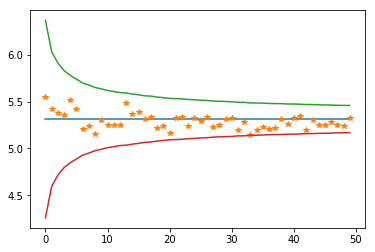

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

# Calculate the analytical call value of the barrier option

def delta_plus(tau, s, sigma, r):
    return (math.log(s)+(r+sigma**2/2)*tau)/(sigma*np.sqrt(tau))

def delta_minus(tau, s, sigma, r):
    return (math.log(s)+(r-sigma**2/2)*tau)/(sigma*np.sqrt(tau))

p1 = (norm.cdf(delta_plus(T, S_0/K, sigma, r))-norm.cdf(delta_plus(T, S_0/L, sigma, r)))*S_0
p2 = (norm.cdf(delta_minus(T, S_0/K, sigma, r))-norm.cdf(delta_minus(T, S_0/L, sigma, r)))*K*np.exp(-r*T)
p3 = (norm.cdf(delta_plus(T, L**2/(K*S_0), sigma, r))-norm.cdf(delta_plus(T, L/S_0, sigma, r)))*L*(S_0/L)**(-2*r/sigma**2)
p4 = (norm.cdf(delta_minus(T, L**2/(K*S_0), sigma, r))-norm.cdf(delta_minus(T, L/S_0, sigma, r)))*K*np.exp(-r*T)*(S_0/L)**(1-2*r/sigma**2)

analytical_callprice = p1-p2-p3+p4

# Plotting the graph
plt.plot([analytical_callprice]*50)
plt.plot(call_est, '*')
plt.plot(analytical_callprice + np.array(call_std)*3)
plt.plot(analytical_callprice - np.array(call_std)*3)
plt.show()

## Bibliography

[1] Shreve, Steven E (2004). Stochastic Calculus for Finance II. Springer-Verlag New York, LLC.
